<a href="https://colab.research.google.com/github/YinYinTan/CIND820FinalProject/blob/main/4_Random_Forest_Classification_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Forest Classification Models
Evaluations using Train-Test Split

In [1]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.feature_selection import RFE

In [2]:
import pandas as pd

#Read file
df = pd.read_csv('3a. Working Dataset.csv', index_col=None)

# All Features

In [20]:
#Split dataframe, using 80% for training and 20% for testing
from sklearn.model_selection import train_test_split

X = df.drop(['Worse_MH'],axis=1)
y = df['Worse_MH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=888, stratify=y)

In [21]:
#Apply Synthetic Minority Oversampling Technique (SMOTE) to training set to correct class imbalance
smote = SMOTE(random_state = 888)
X_train, y_train = smote.fit_resample(X_train, y_train)

#Random forest classification model
model = RandomForestClassifier(random_state=888)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

#Evaluation of random forest classification model
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1-score:", metrics.f1_score(y_test, y_pred))
print("Area Under Curve (AUC):", metrics.roc_auc_score(y_test, y_pred))

Accuracy: 0.7517321016166282
Precision: 0.8331877729257642
Recall: 0.7996647108130763
F1-score: 0.8160821214713431
Area Under Curve (AUC): 0.7226523925122894


# 5 Selected Features - Filter Method
[Previous "All Features" section must be run first]

In [24]:
#Identify top 20 features
model = RandomForestClassifier(random_state=888)
model.fit(X_train, y_train)

feature_names = df.drop(['Worse_MH'],axis=1).columns

feature_imp = pd.Series(model.feature_importances_,index=feature_names).sort_values(ascending=False)
feature_imp = feature_imp[:20]

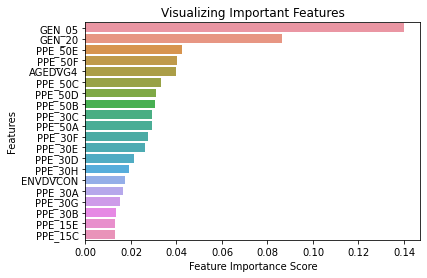

In [25]:
#Plot top 15 features
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

Based on the bar graph above, it was decided to build a random forest model using only the top 5 features

In [26]:
#Obtain names of top 5 variables
top_five = feature_imp[:5].index
top_five

Index(['GEN_05', 'GEN_20', 'PPE_50E', 'PPE_50F', 'AGEDVG4'], dtype='object')

In [27]:
#Split dataframe, using 80% for training and 20% for testing
from sklearn.model_selection import train_test_split

#Only select top 5 variables for X
X = df.loc[:,top_five]
y = df['Worse_MH']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=888, stratify=y)

In [28]:
#Apply Synthetic Minority Oversampling Technique (SMOTE) to training set to correct class imbalance
smote = SMOTE(random_state = 888)
X_train, y_train = smote.fit_resample(X_train, y_train)

#Random forest classification model
model = RandomForestClassifier(random_state=888)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

#Evaluation of random forest classification model
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1-score:", metrics.f1_score(y_test, y_pred))
print("Area Under Curve (AUC):", metrics.roc_auc_score(y_test, y_pred))

Accuracy: 0.7323903002309469
Precision: 0.8505526189332052
Recall: 0.7418273260687342
F1-score: 0.7924781732706514
Area Under Curve (AUC): 0.7266650545000444


# 5 Selected Features using Recursive Feature Elimination (RFE) - Wrapper Method

In [29]:
#Split dataframe, using 80% for training and 20% for testing
from sklearn.model_selection import train_test_split

X = df.drop(['Worse_MH'],axis=1)
y = df['Worse_MH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=888, stratify=y)

In [30]:
#Apply Synthetic Minority Oversampling Technique (SMOTE) to training set to correct class imbalance
smote = SMOTE(random_state = 888)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [33]:
#Random forest classification model with RFE for 5 features
model = RandomForestClassifier(random_state=888)

rfe = RFE(estimator=model, n_features_to_select=5)
fit = rfe.fit(X_train, y_train)

for feature in fit.support_.nonzero():
  print('5 selected features:', X_train.columns[feature])

5 selected features: Index(['PPE_50A', 'PPE_50C', 'PPE_50E', 'GEN_05', 'GEN_20'], dtype='object')


In [32]:
y_pred=fit.predict(X_test)

#Evaluation of random forest classification model
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1-score:", metrics.f1_score(y_test, y_pred))
print("Area Under Curve (AUC):", metrics.roc_auc_score(y_test, y_pred))

Accuracy: 0.6986143187066974
Precision: 0.8465909090909091
Recall: 0.6869237217099748
F1-score: 0.7584451642757983
Area Under Curve (AUC): 0.7057067588141711
